In [2]:
from keras.models import Model
from keras.layers import LSTM, Dense, Input, Embedding, Concatenate,InputSpec, Activation, Lambda
from keras import backend as K
from keras.engine.topology import Layer
from keras.optimizers import Adam
import numpy as np
import pandas
import itertools
import re
import os
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.metrics import cohen_kappa_score
from keras.callbacks import EarlyStopping
from scipy import stats
import numpy 

Using TensorFlow backend.


# Model definitions here
Few custom layers are defined in keras

In [3]:
def create_model(input_dim = 300,lstm_op_dim=50,vocab_size=4000,embed_dim=300,max_len=1000,coherence_width=50,k=6, start=3, model_type='tensor'):
    if (model_type == 'tensor'):
        inputs = Input(shape=(max_len,input_dim))
        lstm = LSTM(lstm_op_dim, return_sequences = True)(inputs)    
        bilinear_products=Neural_Tensor_layer(output_dim=k,input_dim=lstm_op_dim)
        pairs = [((start + i * coherence_width) % max_len, (start + i * coherence_width + coherence_width) % max_len) for i in range(int(max_len/coherence_width))]
        similarity_pairs = [ (Lambda(lambda t: t[:, p[0], :])(lstm), Lambda(lambda t: t[:, p[1], :])(lstm)) for p in pairs]
        sigmoid_layer = Dense(1, activation="sigmoid")
        similarities = [sigmoid_layer(bilinear_products([w[0], w[1]])) for w in similarity_pairs]  
        tmp = Temporal_Mean_Pooling()(lstm)
        simi = Concatenate()([i for i in similarities])
        tmp_simi = Concatenate()([tmp,simi])
        dense1 = Dense(256,activation='relu')(tmp_simi)
        dense2 = Dense(64,activation='relu')(dense1)
        out = Dense(1,activation='linear')(dense2)
        model = Model(inputs = inputs, outputs = out)
    elif(model_type == 'lstm'):
        inputs = Input(shape=(max_len,input_dim))
        lstm = LSTM(lstm_op_dim, return_sequences = False)(inputs)
        op = Dense(1,activation='linear')(lstm)
        model = Model(inputs = inputs, outputs = op)            
    return model

class Temporal_Mean_Pooling(Layer): 
    def __init__(self, **kwargs):
        self.input_spec=InputSpec(ndim=3)
        super(Temporal_Mean_Pooling,self).__init__(**kwargs)

    def call(self,x):
        mask=K.mean(K.ones_like(x),axis=-1)
        return K.sum(x,axis=-2)/K.sum(mask,axis=-1,keepdims=True)

    def compute_output_shape(self,input_shape):
        return (input_shape[0],input_shape[2])
    
class Neural_Tensor_layer(Layer):
    def __init__(self,output_dim,input_dim=None, **kwargs):
        self.output_dim=output_dim
        self.input_dim=input_dim
        if self.input_dim:
            kwargs['input_shape']=(self.input_dim,)
        super(Neural_Tensor_layer,self).__init__(**kwargs)

    def build(self,input_shape):
        mean=0.0
        std=1.0
        k=self.output_dim
        d=self.input_dim
        W=stats.truncnorm.rvs(-2 * std, 2 * std, loc=mean, scale=std, size=(k,d,d))
        V=stats.truncnorm.rvs(-2 * std, 2 * std, loc=mean, scale=std, size=(2*d,k))
        self.W=K.variable(W)
        self.V=K.variable(V)
        self.b=K.zeros((self.input_dim,))
        self.trainable_weights=[self.W,self.V,self.b]

    def call(self,inputs,mask=None):
        e1=inputs[0]
        e2=inputs[1]
        batch_size=K.shape(e1)[0]
        k=self.output_dim
        feed_forward=K.dot(K.concatenate([e1,e2]),self.V)
        bilinear_tensor_products = [ K.sum((e2 * K.dot(e1, self.W[0])) + self.b, axis=1) ]
        for i in range(k)[1:]:	
            btp=K.sum((e2*K.dot(e1,self.W[i]))+self.b,axis=1)
            bilinear_tensor_products.append(btp)
        result=K.tanh(K.reshape(K.concatenate(bilinear_tensor_products,axis=0),(batch_size,k))+feed_forward)
        return result

    def compute_output_shape(self, input_shape):
        batch_size=input_shape[0][0]
        return(batch_size,self.output_dim)

# Data Preprocessing
The following functions read the essays from the file and converts them into glove embeddings that can be fed as input 

In [4]:
def load_training_data(train_path,essay_set = 1):
    train_path = train_path
    training_data = pandas.read_excel(train_path, delimiter='\t')
    resolved_score = training_data[training_data['essay_set'] == essay_set]['domain1_score']
    essay_ids = training_data[training_data['essay_set'] == essay_set]['essay_id']
    essays = training_data[training_data['essay_set'] == essay_set]['essay']
    essay_list = []
    for idx, essay in essays.iteritems():
        essay_list.append(clean_tokenize(essay))
    return essay_list, resolved_score.tolist(), essay_ids.tolist()

def clean_tokenize(data):
    data = re.sub(r"[^A-Za-z0-9(),!?\'\`]", " ", data)
    data = re.sub(r"\'s", " \'s", data)
    data = re.sub(r"\'ve", " \'ve", data)
    data = re.sub(r"n\'t", " n\'t", data)
    data = re.sub(r"\'re", " \'re", data)
    data = re.sub(r"\'d", " \'d", data)
    data = re.sub(r"\'ll", " \'ll", data)
    data = re.sub(r",", " , ", data)
    data = re.sub(r"!", " ! ", data)
    data = re.sub(r"\(", " ( ", data)
    data = re.sub(r"\)", " ) ", data)
    data = re.sub(r"\?", " ? ", data)
    data = re.sub(r"\s{2,}", " ", data)
    data = data.lower()
    return [x.strip() for x in re.split('(\W+)?', data) if x.strip()]


def score_range(self):
    return {"1": (2, 12),"2": (1, 6),"3": (0, 3),"4": (0, 3),"5": (0, 4),"6": (0, 4),"7": (0, 30),"8": (0, 60)}

def normalize_score(self, essay_set_id, score):
    lo, hi = self.score_range[str(essay_set_id)]
    score = float(score)
    return (score - lo) / (hi - lo)


def vectorize_data(data, word_idx, sentence_size):
    E = []
    for essay in data:
        ls = max(0, sentence_size - len(essay))
        wl = []
        for w in essay:
            if w in word_idx:
                wl.append(word_idx[w])
            else:
                wl.append(0)
        wl += [0]*ls
        E.append(wl)
    return E

def convert_to_vec(vectorized_data, word2vec):
    total_vector = []
    for essay in vectorized_data:
        essay_vector = []
        for word in essay:
            essay_vector.append((word2vec[word]))
        total_vector.append(essay_vector)
    return total_vector

def convertword2vec(dim=300):
    word2vec = []
    word_idx = {}
    word2vec.append([0]*dim)
    count = 1
    with open('glove.6B.300d.txt',encoding="utf8") as f:
        for line in f:
            l = line.split()
            word = l[0]
            vector = list(map(float, l[1:]))
            word_idx[word] = count
            word2vec.append(vector)
            count += 1
    return word_idx, word2vec
word_idx, word2vec = convertword2vec()


The following lines are used to call the above preprocessing function specific to some essay set 

In [5]:
essay_set_id = 1
essay_list, resolved_scores, essay_id = load_training_data('training_set_rel3.xlsx',essay_set_id)
vocab_size = len(word_idx) + 1
max_sent_size = 1000
vectorized_data = vectorize_data(essay_list, word_idx, max_sent_size)
X = convert_to_vec(vectorized_data, word2vec)

C:\Users\priya\Anaconda3\envs\tensorflow1\lib\re.py:212: FutureWarning: split() requires a non-empty pattern match.
  return _compile(pattern, flags).split(string, maxsplit)


# Initialising the model and Training
Create the model with the choice of paramaters for cohernce width, tensor slices, model type

In [6]:

model = create_model(k=6, coherence_width=50, model_type='tensor')

model.compile(optimizer=Adam(lr=0.001,decay=1e-6),
               loss='mse')

model.summary()


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 1000, 300)    0                                            
__________________________________________________________________________________________________
lstm_1 (LSTM)                   (None, 1000, 50)     70200       input_1[0][0]                    
__________________________________________________________________________________________________
lambda_1 (Lambda)               (None, 50)           0           lstm_1[0][0]                     
__________________________________________________________________________________________________
lambda_2 (Lambda)               (None, 50)           0           lstm_1[0][0]                     
__________________________________________________________________________________________________
lambda_3 (

Make a test-train split and Train

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, resolved_scores, test_size=0.3, random_state=42)
X_train=numpy.array(X_train)
X_test=numpy.array(X_test)
y_train=numpy.array(y_train)
y_test=numpy.array(y_test)
earlystopping = EarlyStopping(monitor="val_loss", patience=10)  
model.fit(X_train,y_train,batch_size = 64,epochs = 50,validation_data=(X_test,y_test), callbacks=[earlystopping])

Train on 1248 samples, validate on 535 samples
Epoch 1/50
1248/1248 [==============================] - 69s 56ms/step - loss: 43.5743 - val_loss: 1.3430
Epoch 2/50
1248/1248 [==============================] - 66s 53ms/step - loss: 3.4434 - val_loss: 2.2518
Epoch 3/50
1248/1248 [==============================] - 58s 46ms/step - loss: 1.5423 - val_loss: 1.0333
Epoch 4/50
1248/1248 [==============================] - 58s 46ms/step - loss: 1.0594 - val_loss: 0.9585
Epoch 5/50
1248/1248 [==============================] - 57s 46ms/step - loss: 0.9922 - val_loss: 0.8762
Epoch 6/50
1248/1248 [==============================] - 58s 46ms/step - loss: 0.9345 - val_loss: 0.8454
Epoch 7/50
1248/1248 [==============================] - 57s 46ms/step - loss: 0.8977 - val_loss: 0.8312
Epoch 8/50
1248/1248 [==============================] - 58s 46ms/step - loss: 0.8746 - val_loss: 0.8130
Epoch 9/50
1248/1248 [==============================] - 58s 46ms/step - loss: 0.8743 - val_loss: 0.7959
Epoch 10/50
1248

Predict the outputs for the validation set and get the final QWK score

In [9]:
predictions = model.predict_on_batch(X_test)
model.save('k=6_essaytype=1.h5')
y_val=[int(np.round(a)) for a in y_test]
y_pred=[int(np.round(a)) for a in predictions]
print(cohen_kappa_score(y_val,y_pred,weights='quadratic'))

0.830058207118556


# Graph Actual vs Predicted data

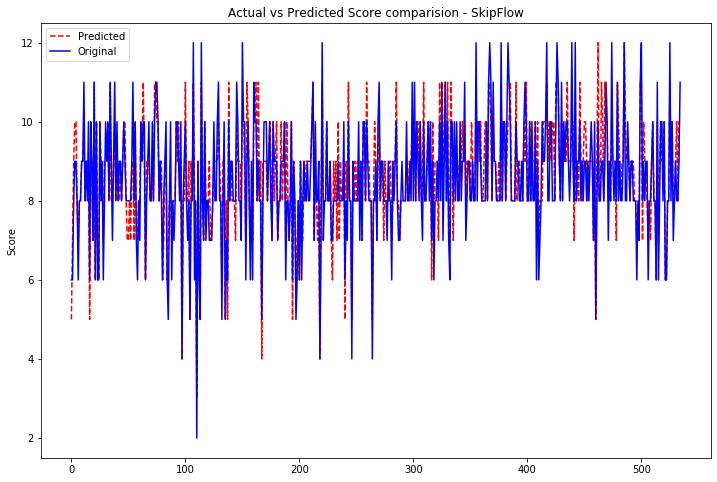

In [10]:
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib import rcParams
rcParams['figure.figsize']=10,6

# plot
fig=plt.figure(figsize=(12,8))
plt.title("Actual vs Predicted Score comparision - SkipFlow")
# plt.xlabel("Essay_id")
plt.ylabel("Score")
plt.plot(y_pred, color='red', label='Predicted', linestyle='dashed')
plt.plot(y_val, color='blue', label='Original', linestyle='solid')
plt.legend()
plt.show()